In [6]:
#! /usr/bin/env python

from generator import BatchGenerator
from datetime import datetime
import numpy as np
import tensorflow as tf
import shutil
import json
import keras
import argparse
import os

from _common.voc import parse_voc_annotation

def init_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    keras.backend.tensorflow_backend.set_session(tf.Session(config=config))


config_path = 'cfgs/signs_tiny_v3.json'

init_session()

with open(config_path) as config_buffer:    
    config = json.loads(config_buffer.read())

###############################
#   Parse the annotations 
###############################

train_imgs, train_labels = parse_voc_annotation(config['train']['train_annot_folder'], 
                                                config['train']['train_image_folder'], 
                                                None,
                                                config['model']['labels'])

# parse annotations of the validation set, if any, otherwise split the training set
if config['valid']['valid_annot_folder']:
    valid_imgs, valid_labels = parse_voc_annotation(config['valid']['valid_annot_folder'], 
                                                config['valid']['valid_image_folder'],
                                                None,
                                                config['model']['labels'])
    split = False
else:
    split = True


if split:
    train_valid_split = int(0.8*len(train_imgs))
    np.random.shuffle(train_imgs)

    valid_imgs = train_imgs[train_valid_split:]
    train_imgs = train_imgs[:train_valid_split]

if len(config['model']['labels']) > 0:
    overlap_labels = set(config['model']['labels']).intersection(set(train_labels.keys()))

    print('Seen labels:\t', train_labels)
    print('Given labels:\t', config['model']['labels'])
    print('Overlap labels:\t', overlap_labels)           

    if len(overlap_labels) < len(config['model']['labels']):
        print('Some labels have no annotations! Please revise the list of labels in the config.json file!')
        exit(1)
else:
    print('No labels are provided. Train on all seen labels.')
    print('Seen labels:\t', train_labels)
    config['model']['labels'] = train_labels.keys()
    with open("labels.json", 'w') as outfile:
        json.dump({"labels" : list(train_labels.keys())},outfile)
        

max_box_per_image = max([len(inst['object']) for inst in (train_imgs + valid_imgs)])

labels = train_labels.keys()

generator = BatchGenerator(
    instances           = train_imgs,
    anchors             = config['model']['anchors'],   
    labels              = list(labels),
    downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
    max_box_per_image   = max_box_per_image,
    batch_size          = 4,
    min_net_size        = config['model']['min_input_size'],
    max_net_size        = config['model']['max_input_size'],
    norm                = None
)

generator = BatchGenerator(
    instances=train_imgs,
    anchors=config['model']['anchors'],
    labels=list(labels),
    downsample=32,  # ratio between network input's size and network output's size, 32 for YOLOv3
    max_box_per_image=max_box_per_image,
    batch_size=config['train']['batch_size'],
    norm=None,
    infer_sz=config['model']['infer_shape']
)

print('Ready')
print(list(labels))

No labels are provided. Train on all seen labels.
Seen labels:	 {'no traffic both ways (prohibitory)': 10, 'no overtaking (trucks) (prohibitory)': 63, 'road narrows (danger)': 2, 'speed limit 100 (prohibitory)': 37, 'construction (danger)': 21, 'no entry (other)': 25, 'priority road (other)': 54, 'snow (danger)': 14, 'slippery road (danger)': 13, 'restriction ends (overtaking) (other)': 6, 'bend left (danger)': 2, 'uneven road (danger)': 9, 'stop (other)': 22, 'bend (danger)': 5, 'cycles crossing (danger)': 4, 'speed limit 70 (prohibitory)': 31, 'keep right (mandatory)': 57, 'restriction ends (other)': 3, 'danger (danger)': 27, 'priority at next intersection (danger)': 26, 'speed limit 20 (prohibitory)': 4, 'give way (other)': 52, 'speed limit 50 (prohibitory)': 59, 'animals (danger)': 1, 'restriction ends 80 (other)': 17, 'no overtaking (prohibitory)': 32, 'roundabout (mandatory)': 7, 'speed limit 80 (prohibitory)': 37, 'go right (mandatory)': 13, 'speed limit 120 (prohibitory)': 47, 

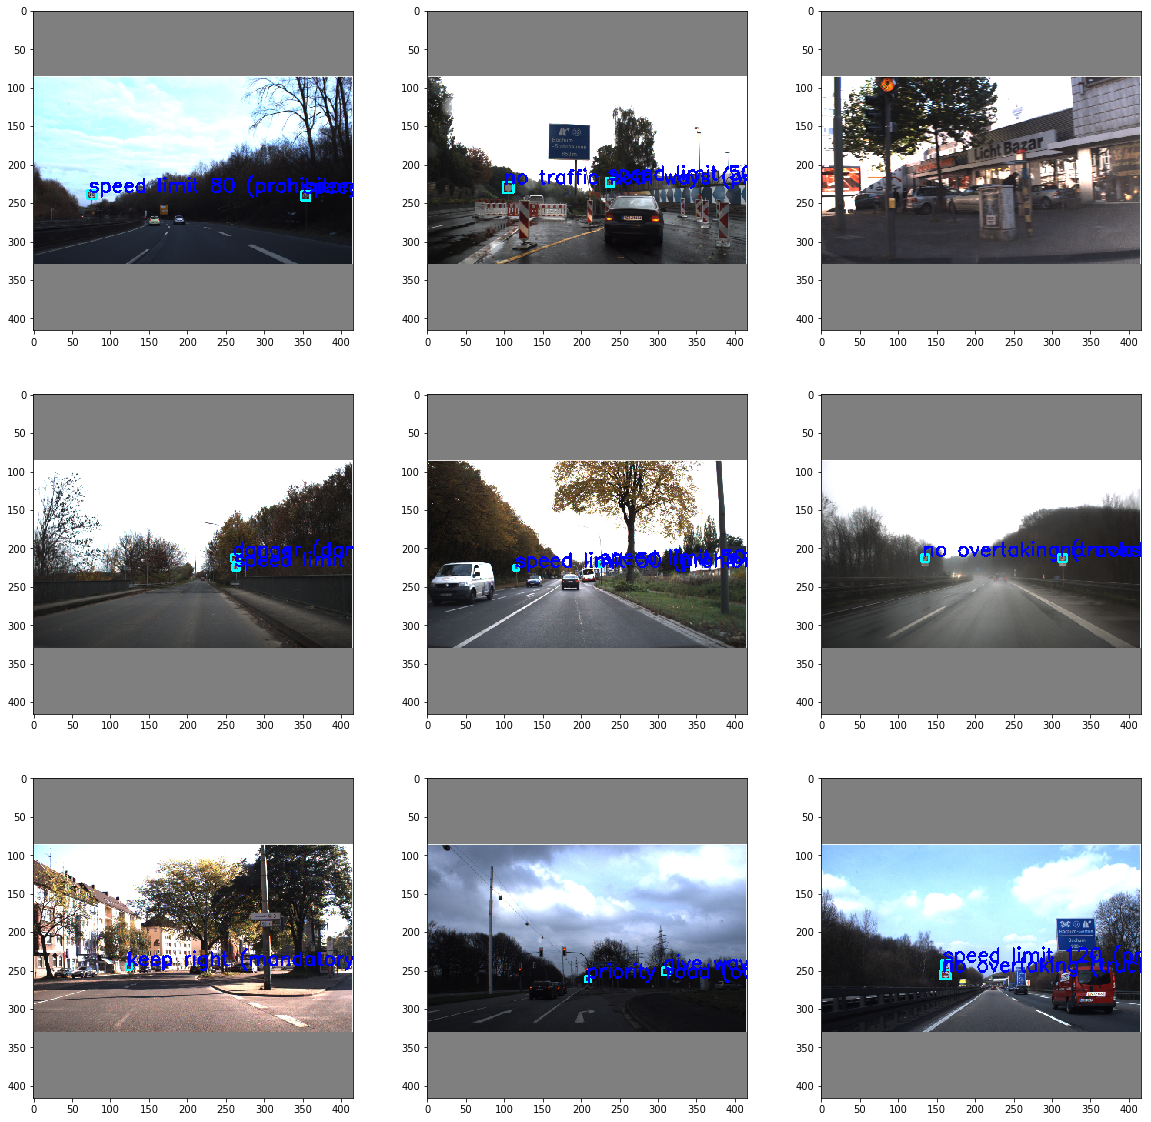

In [7]:
import matplotlib.pyplot as plt
import cv2
from utils.utils import preprocess_input
import numpy as np
%matplotlib inline

def im_show(cv_img):
    cv_img = cv_img.astype(np.uint8)
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_img)
    
plt.figure(figsize=(20,20))
    
for r in range(3):
    img_batch = generator[r][0:3]

    for i, image in enumerate(img_batch):
        idx = (r * len(img_batch)) + i + 1
        plt.subplot(3, len(img_batch), idx)
        
        im_show(image)
#         print(image.shape)

#     for i in range(len(img_batch)):
#         img = train_generator.load_image(i)
#         img = preprocess_input(img, 416, 416)
        
#         idx = (3 * len(img_batch)) + i + 1
#         plt.subplot(4, len(img_batch), idx)
        
#         im_show(img[0]*255)
        